# Zvi Badash 214553034
## Assignment 13 - Diabetes dataset

The video explaining the excercise can be found [here](https://youtu.be/Pwf_EDyvbn4)

Imports and random seed

In [31]:
!pip install tabulate
from tabulate import tabulate

import torch
import pandas as pd
import tqdm as tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [32]:
torch.manual_seed(0)

## Parts 1 & 2 - Read in the data and create a new `classes` column

In [33]:
def read_data(csv_file, classes):
    # A hack to make the number of classes available all around the notebook
    global num_classes
    num_classes = classes

    # Read the data
    data_frame = pd.read_csv(csv_file, delimiter='\t')

    # Create a new column with the number of classes
    data_frame['Class'] = pd.qcut(data_frame['Y'], num_classes, labels=False)
    return data_frame

## Part 3 - Create a dataset class

In [34]:
class ClassificationDataset(Dataset):
    """
    This class overrides the Dataset class from torch.utils.data.Dataset
    The class loads the diabetes dataset and creates a dataset object
    """
    def __init__(self, data_frame, target_col='Class', normalize=True, drop_cols=None):
        # Drop the target column and the columns that were requested to be dropped
        if drop_cols is None:
            drop_cols = [target_col]
        else:
            drop_cols.append(target_col)
        self.X = data_frame.drop(columns=drop_cols).values

        # Convert the data to tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(data_frame[target_col].values)

        # One-hot encode the target column
        self.y = torch.nn.functional.one_hot(self.y, num_classes=num_classes)

        # Normalize the data if requested
        if normalize:
            self._normalize()

    def _normalize(self):
        # Subtract the mean and divide by the standard deviation
        mean = self.X.mean(dim=0)
        std = self.X.std(dim=0)
        self.X = (self.X - mean) / std

    def __getitem__(self, index):
        # Return a single item from the dataset
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.y)

## Part 4 - Train/test split and dataloader creation

In [35]:
def train_test_split(data_frame, train_split=0.8, drop_y=False, batch_size=10):
    # Create a dataset object
    drop_cols = ['Y'] if drop_y else None
    dataset = ClassificationDataset(data_frame, drop_cols=drop_cols)

    # Split the dataset into train and test
    train_size = int(train_split * len(dataset)) # 80% of the data is used for training
    test_size = len(dataset) - train_size # 20% of the data is used for testing
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # Create dataloaders
    train_dl, test_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

    # Return the dataloaders
    return train_dl, test_dl

## Part 5 - Printing a batch of data from the train dataloader

In [36]:
def get_batch(dataloader):
    # Return a single batch from a dataloader
    return next(iter(dataloader))

## Part 6 - Creating models to predict the new class column

In [37]:
def accuracy(y_true, y_pred):
    # Calculate the accuracy of a model on y_true and y_pred
    _, y_true = torch.max(y_true, dim=1)
    _, y_pred = torch.max(y_pred, dim=1)
    return (y_true == y_pred).sum().item() / len(y_true)

In [38]:
# Set the device to gpu if available, otherwise use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [39]:
# Create a model with the given number of input features, dropout rate and activation function
def create_model(in_features, dropout_rate=0.5, activation=torch.nn.Tanh):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features, 64),
        activation(),
        torch.nn.Linear(64, 32),
        activation(),
        torch.nn.Linear(32, 16),
        activation(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(16, num_classes),
    ).to(device)

In [40]:
# Set the loss function to CE loss
cross_entropy = torch.nn.CrossEntropyLoss()

In [41]:
# The training loop
def train(model, train_dl, lr, epochs=1000):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_hist = []

    model.train()
    for epoch in range(epochs):
        with tqdm.tqdm(train_dl, unit="batch") as t_epoch:
            for idx, (inputs, labels) in enumerate(t_epoch):
                t_epoch.set_description(f"Epoch {epoch}")

                # Forward pass
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = cross_entropy(outputs, labels.float())

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Logging
                t_epoch.set_postfix(Loss=loss.item())
            loss_hist.append(loss.item())
    return loss_hist

In [42]:
# Calculate the accuracy of the model on the test set
def test_accuracy(model, test_dl):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            return accuracy(labels, outputs)

# Finally, use all the functions defined above to train a model on the diabetes dataset

## Deciles models

In [43]:
df = read_data('diabetes.csv', 10)
train_dataloader, test_dataloader = train_test_split(df)
print(get_batch(train_dataloader))

[tensor([[-1.1075,  1.0643, -1.3073,  0.2424, -0.1774, -0.7707,  2.5677, -1.6043,
         -1.8234,  0.0644, -1.3897],
        [ 0.9522,  1.0643, -0.1756, -0.6975, -0.1485,  0.0250, -0.8341,  0.7205,
          0.6286,  0.5863, -0.2741],
        [ 0.2656,  1.0643, -0.4698, -0.6252,  0.2271,  0.5971, -0.4475,  0.7205,
         -0.1277, -0.0226, -1.3118],
        [ 0.4182,  1.0643,  2.2010,  1.4715, -0.7553, -0.5603, -0.5248, -0.0544,
          0.0779,  0.8472,  2.1904],
        [ 0.7233,  1.0643, -0.1982,  1.2546, -0.7553, -0.1591, -1.6072,  1.4954,
          0.2312, -0.4576,  1.3603],
        [-0.7261,  1.0643,  0.1186, -0.1191, -1.5355, -1.3165, -0.1383, -0.8294,
         -0.9539,  0.6732, -1.1043],
        [-0.4972, -0.9375,  0.8429, -0.2637, -0.2063, -0.0210, -0.0610, -0.0544,
         -0.2498, -0.8055, -0.0666],
        [ 0.0368,  1.0643, -0.1077, -0.2637, -0.3219, -0.2906,  0.1710, -0.8294,
         -0.1277, -1.4144, -0.7800],
        [ 0.3419,  1.0643,  0.0507, -0.1191, -0.1196,  

In [44]:
model_with_Y = create_model(len(df.columns) - 1)
loss_h = train(model_with_Y, train_dataloader, lr=0.01, epochs=500)

Epoch 499: 100%|██████████| 36/36 [00:00<00:00, 223.62batch/s, Loss=0.277]


In [45]:
deciles_with_Y_acc = test_accuracy(model_with_Y, test_dataloader)
print(f'Accuracy: {100 * deciles_with_Y_acc:.2f}%')

Accuracy: 85.39%


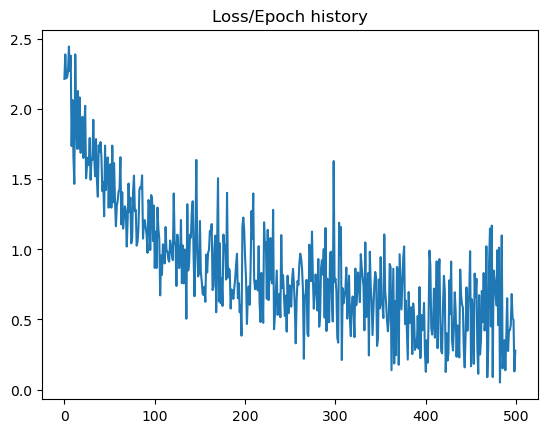

In [46]:
# Set plot title
plt.title('Loss/Epoch history')
plt.plot(loss_h, label='Loss')

In [47]:
train_dataloader, test_dataloader = train_test_split(df, drop_y=True)
print(get_batch(train_dataloader))

[tensor([[-0.4972, -0.9375, -0.9678, -0.6975,  0.6894,  0.7615,  0.7895, -0.0544,
         -0.6982,  0.2383],
        [ 0.1130,  1.0643,  0.7298, -0.0229,  3.2033,  4.1745, -1.2980,  3.8899,
          0.3269,  1.5431],
        [-0.8024, -0.9375, -1.1489, -1.6374, -0.6975, -1.8163,  2.9543, -1.6043,
         -0.4032, -0.1096],
        [-0.7261,  1.0643, -1.1715, -0.3360, -0.2063, -0.1657,  0.7895, -0.8294,
         -1.1122,  0.5863],
        [ 0.5707,  1.0643, -0.7414,  0.6762, -0.2352,  0.0316, -0.2156, -0.0544,
         -0.3142, -1.0664],
        [ 0.1893, -0.9375, -0.4246, -1.1313,  0.6605,  0.4327,  1.1761, -0.8294,
         -0.2290, -0.0226],
        [ 1.2573,  1.0643,  1.6125,  0.5316,  0.0248,  0.3538, -1.1434,  0.7205,
          0.6286,  0.9342],
        [-1.1075,  1.0643, -0.2435,  1.1823,  1.1806,  1.5309, -0.8341,  1.4954,
          0.6418, -0.1096],
        [-0.4972,  1.0643,  0.9561,  0.4593,  2.3075,  1.8663,  0.0164,  0.7205,
          1.5580,  1.2821],
        [ 0.1893, 

In [48]:
model_without_Y = create_model(len(df.columns) - 2)
print(model_without_Y)
loss_h = train(model_without_Y, train_dataloader, lr=0.01, epochs=750)

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Tanh()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=16, out_features=10, bias=True)
)


Epoch 749: 100%|██████████| 36/36 [00:00<00:00, 287.66batch/s, Loss=0.844]


In [49]:
deciles_without_Y_acc = test_accuracy(model_without_Y, test_dataloader)
print(f'Accuracy: {100 * deciles_without_Y_acc:.3f}%')

Accuracy: 15.730%


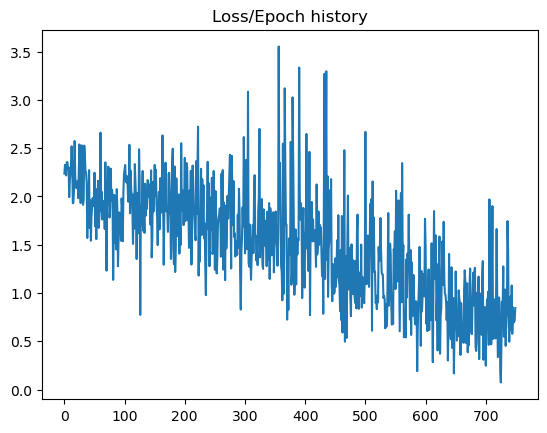

In [50]:
plt.title('Loss/Epoch history')
plt.plot(loss_h, label='Loss')

## Percentiles models

In [51]:
df = read_data('diabetes.csv', 100)
train_dataloader, test_dataloader = train_test_split(df)
print(get_batch(train_dataloader))

[tensor([[ 1.0284,  1.0643,  0.0734,  1.4715, -0.1774,  0.2815, -1.1434,  0.7205,
          0.2797,  0.7602, -0.3001],
        [-2.0229, -0.9375, -0.7641, -1.5651, -0.8131, -0.5800,  0.3256, -0.8294,
         -1.5559, -0.0226,  0.6209],
        [ 0.1130,  1.0643,  0.6392,  1.7607, -0.7842, -0.9943,  0.3256, -0.8294,
          0.1815,  0.3253,  0.6468],
        [-0.5735, -0.9375, -0.3793, -0.8421, -0.0618, -0.2380,  0.7895, -0.8294,
         -0.1878, -1.1534,  0.2058],
        [ 0.0368,  1.0643,  0.2318, -0.4083, -0.3508, -0.0802, -0.9887,  0.7205,
          0.5052,  0.4993, -0.5336],
        [-0.5735, -0.9375,  1.6804,  2.0738, -0.0618,  0.3801, -0.3702,  0.0695,
         -0.6201,  0.7602,  1.3603],
        [ 0.1893, -0.9375,  0.3450,  0.0978,  0.1982,  0.2223, -0.6022,  0.7205,
          0.8183,  2.4999,  1.5029],
        [-0.4972, -0.9375,  0.6392, -0.1191,  1.7296,  1.9321, -0.3702,  1.4954,
          0.6939,  0.0644, -0.3909],
        [ 0.7996,  1.0643, -0.6283, -1.5651, -0.2641, -

In [52]:
model_with_Y = create_model(len(df.columns) - 1)
loss_h = train(model_with_Y, train_dataloader, lr=0.01, epochs=1000)

Epoch 999: 100%|██████████| 36/36 [00:00<00:00, 256.06batch/s, Loss=1.97]


In [53]:
percentiles_with_Y_acc = test_accuracy(model_with_Y, test_dataloader)
print(f'Accuracy: {100 * percentiles_with_Y_acc:.2f}%')

Accuracy: 2.25%


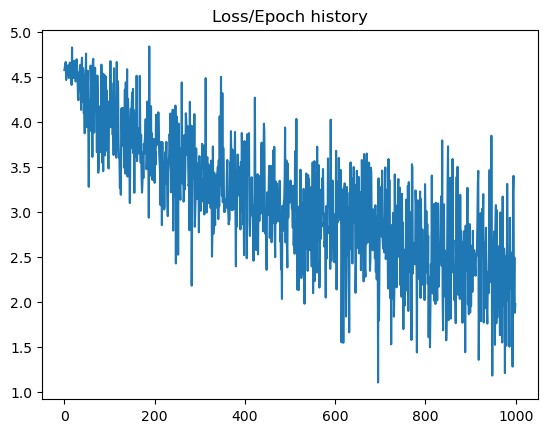

In [54]:
# Set plot title
plt.title('Loss/Epoch history')
plt.plot(loss_h, label='Loss')

In [55]:
train_dataloader, test_dataloader = train_test_split(df, drop_y=True)
print(get_batch(train_dataloader))

[tensor([[ 0.3419, -0.9375, -0.5151,  0.7485, -0.1485, -0.0670, -0.2929, -0.0544,
          0.3269,  0.3253],
        [ 0.3419, -0.9375, -0.9452, -1.2036, -0.7264, -1.1324,  1.5626, -1.6043,
         -0.8940,  0.8472],
        [-1.7940,  1.0643, -0.4698,  0.0255, -0.7842, -0.5537,  0.3256, -0.8294,
         -1.5148, -0.3706],
        [-0.4972, -0.9375, -1.4657, -1.3482, -1.2465, -1.0600,  0.4029, -0.8294,
         -1.8718, -1.0664],
        [ 0.1893,  1.0643, -0.1077, -1.3482,  1.4696,  1.7611, -0.8341,  1.4954,
          0.8304,  0.4123],
        [ 1.3336,  1.0643, -0.0398,  1.3992,  1.9030,  2.2872,  0.4802,  0.3718,
         -0.7521,  0.0644],
        [-1.7940,  1.0643, -0.6509, -0.4806, -1.3332, -1.1390,  0.4029, -0.8294,
         -2.0251, -0.7185],
        [-2.0992, -0.9375, -1.4205, -2.2881, -1.5644, -1.5269,  0.3256, -0.8294,
         -1.0473, -0.1966],
        [-0.1158, -0.9375,  1.1825, -0.7698, -1.0154, -0.9022, -1.5299,  0.7980,
          1.0664,  1.1951],
        [-1.1075, 

In [56]:
model_without_Y = create_model(len(df.columns) - 2)
print(model_without_Y)
loss_h = train(model_without_Y, train_dataloader, lr=0.01, epochs=1000)

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Tanh()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=16, out_features=100, bias=True)
)


Epoch 999: 100%|██████████| 36/36 [00:00<00:00, 209.46batch/s, Loss=3.98]


In [57]:
percentiles_without_Y_acc = test_accuracy(model_without_Y, test_dataloader)
print(f'Accuracy: {100 * percentiles_without_Y_acc:.2f}%')

Accuracy: 2.25%


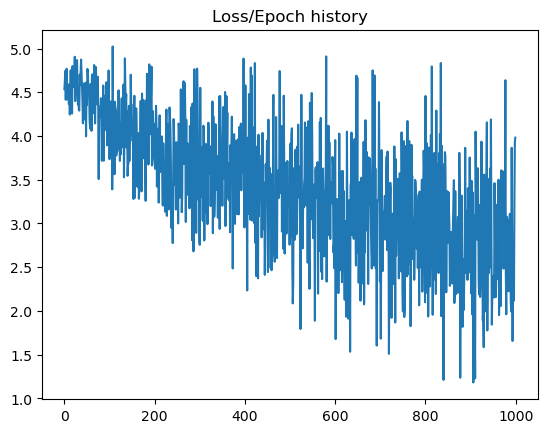

In [58]:
plt.title('Loss/Epoch history')
plt.plot(loss_h, label='Loss')

In [59]:
print(tabulate([
    ['Deciles', f'{100 * deciles_with_Y_acc:.2f}%', f'{100 * deciles_without_Y_acc:.2f}%'],
    ['Percentiles', f'{100 * percentiles_with_Y_acc:.2f}%', f'{100 * percentiles_without_Y_acc:.2f}%']
], headers=['With Y', 'Without Y'], tablefmt='fancy_grid'))

╒═════════════╤══════════╤═════════════╕
│             │ With Y   │ Without Y   │
╞═════════════╪══════════╪═════════════╡
│ Deciles     │ 85.39%   │ 15.73%      │
├─────────────┼──────────┼─────────────┤
│ Percentiles │ 2.25%    │ 2.25%       │
╘═════════════╧══════════╧═════════════╛


To conclude, of course the preferred class type would be deciles and not percentiles because a large number of classes like 100 (with the limited dataset we have) does nothing but harm the generalization capability of the model and does not really provide much better information about the target variable Y.